# LSTM

LSTM-RNN to predict net migration.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, TensorDataset
#from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device}")

Using cpu


In [2]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])

# Also MinMax-scaling what will be target; but saving orig. min and
#  max so we can rescale later:
omin, omax = data["net_migration"].min(), data["net_migration"].max()
data["net_migration"] = minmax_scale(data["net_migration"])

# Drop 2022 & 2023
data = data[data["year"] < 2022]

data = data.sort_values(["iso3", "year"]).reset_index(drop=True)

## Data Prep

Here we have to make up our mind on what to predict:

* **Predict the full sequence:** Build a model that takes as input the features for an entire time series for a dyad & predicts how migration for that dyad developed

* **Predict the next year:** Hold back the last year (element) of a series. Give the model all other elements of the series & ask it to predict the last value for migration (basically: given past development of features & target in the series, how will the next target value look given the next feature values)

*The approach:*

* *Inputs:* Features and target at $t$
* *Output:* Target at $t+1$

(See for example [this paper](https://arxiv.org/pdf/2005.09902))

The model will be fed a sequence of a specified length (can change this) of features to predict the target (i.e. will get sequence of features & target from 5 years to predict target (number of migrants) in the next year)

In [3]:

data["net_migration_tp1"] = data.groupby(by="iso3").shift(-1)["net_migration"]
data = data.dropna(subset="net_migration_tp1")

In [4]:
target = "net_migration_tp1"
features = data.drop(["iso3", "year", target], axis=1).columns.tolist()

data_test = data[data['year'] >= 2018]
data_val = data[(data['year'] >= 2016) & (data['year'] <= 2017)]
data_train = data[~data.apply(tuple, 1).isin(pd.concat([data_test, data_val]).apply(tuple, 1))]

Turn into sequences:

In [5]:
def create_sequences(df: pd.DataFrame, seq_length: int) -> list:
    sequences = []
    for _, group in df.groupby("iso3"):
        for i in range(len(group) - seq_length):
            seq = group.iloc[i:i+seq_length][features].values
            target = group.iloc[i+seq_length]["net_migration_tp1"]
            sequences.append((seq, target))
    return sequences

seq_length = 1  # Number of time steps used for prediction
train_seqs = create_sequences(data_train, seq_length)
val_seqs = create_sequences(data_val, seq_length)
test_seqs = create_sequences(data_test, seq_length)



Custom Dataset:

In [6]:
class MigrationDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

Initial split:

In [7]:

train_set = MigrationDataset(train_seqs)
val_set = MigrationDataset(val_seqs)
test_set = MigrationDataset(test_seqs)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


## Model

In [8]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Parameters:

In [9]:
input_size = len(train_seqs[0][0][0])  # Number of features per time step; just use the first sequence to check...
hidden_size = 256
num_layers = 2
output_size = 1  # Predicting a single value (migration flow) for the next year

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

Loss function and optimizer:

In [10]:
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Implement setting checkpoints & restoring best weights:

In [11]:
def checkpoint(model) -> None:
    torch.save(model.state_dict(), "checkpoint.pth")

def restore_best_weights(model) -> None:
    model.load_state_dict(torch.load("checkpoint.pth"))

Implement early stopping:

In [12]:
class EarlyStopping:
    
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("Inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            

stopper = EarlyStopping()

Lay out training procedure:

In [13]:
def validate(model: LSTMModel, val_loader: DataLoader, criterion: nn.HuberLoss) -> float:
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for features, targets in val_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1)  
            loss = criterion(pred, targets)
            total_loss += loss.item()
    
    return total_loss

def train(model: LSTMModel, train_loader: DataLoader, val_loader: DataLoader, epochs: int, criterion: nn.HuberLoss) -> list:

    losses = []

    for epoch in range(epochs):

        # Train step

        model.train()

        epoch_train_loss = 0

        for features, targets in train_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1) 
            loss = criterion(pred, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Validation step

        epoch_val_loss = validate(model, val_loader, criterion)

        stopper(epoch_val_loss)

        print(f"Epoch {epoch+1} done: Training loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}, Patience counter: {stopper.counter}")
        losses.append({"epoch": epoch+1, "training": epoch_train_loss, "validation": epoch_val_loss})
        
        if stopper.counter == 0:
            checkpoint(model)
        
        if stopper.early_stop:
            print(f"Patience exceeded, stopping training & restoring best weights...")
            restore_best_weights(model)
            break
        


    return losses

In [14]:
losses = train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=100, criterion=criterion)

Epoch 1 done: Training loss: 2.0889, Validation loss: 0.0020, Patience counter: 0
Epoch 2 done: Training loss: 0.0310, Validation loss: 0.0018, Patience counter: 0
Epoch 3 done: Training loss: 0.0306, Validation loss: 0.0032, Patience counter: 1
Epoch 4 done: Training loss: 0.0299, Validation loss: 0.0028, Patience counter: 2
Epoch 5 done: Training loss: 0.0296, Validation loss: 0.0034, Patience counter: 3
Epoch 6 done: Training loss: 0.0291, Validation loss: 0.0033, Patience counter: 4
Epoch 7 done: Training loss: 0.0285, Validation loss: 0.0027, Patience counter: 5
Epoch 8 done: Training loss: 0.0296, Validation loss: 0.0017, Patience counter: 0
Epoch 9 done: Training loss: 0.0275, Validation loss: 0.0015, Patience counter: 0
Epoch 10 done: Training loss: 0.0273, Validation loss: 0.0026, Patience counter: 1
Epoch 11 done: Training loss: 0.0267, Validation loss: 0.0024, Patience counter: 2
Epoch 12 done: Training loss: 0.0250, Validation loss: 0.0013, Patience counter: 0
Epoch 13 done

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_20476\3484606476.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pth"))


## Model Evaluation

<Axes: xlabel='epoch', ylabel='value'>

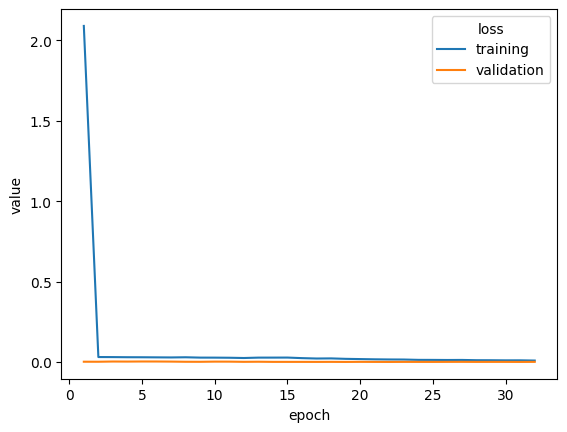

In [15]:
losses = pd.DataFrame(losses)

sns.lineplot(
    data=losses.melt(id_vars="epoch", var_name="loss"),
    x="epoch",
    y="value",
    hue="loss"
)

In [16]:
def eval(model: LSTMModel, test_loader: DataLoader):
    model.eval()
    
    mse = []
    mae = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            targets = targets.unsqueeze(1)
            
            mse_i = F.mse_loss(outputs, targets, reduction='mean').item()
            mse.append(mse_i)

            mae_i = F.l1_loss(outputs, targets, reduction='mean').item()
            mae.append(mae_i)
    
    metrics = {
        "MSE": np.mean(mse),
        "RMSE": np.sqrt(np.mean(mse)),
        "MAE": np.mean(mae)
    }
    
    return metrics

In [17]:
metrics = eval(model, test_loader)
metrics

{'MSE': 0.00013265035795484437,
 'RMSE': 0.011517393713633495,
 'MAE': 0.0064375056286475486}

In [18]:
scale = omax - omin

print(f"Metrics rescaled to original units:\n\nMSE: {metrics['MSE'] * (scale ** 2)}\nRMSE: {metrics['RMSE'] * scale}\nMAE: {metrics['MAE'] * scale}")

Metrics rescaled to original units:

MSE: 13371280423.132301
RMSE: 115634.25281088774
MAE: 64632.344073935645


In [19]:
def collect_predictions(model: LSTMModel, data_loader: DataLoader) -> tuple:
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, targets in data_loader:
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
    
    return predictions, actuals

# Rescaling back to original units (migrants):

def rescale(scaled: list, omin: float, omax: float) -> np.array:
    return [x * (omax - omin) + omin for x in scaled]

In [20]:
predictions, actuals = collect_predictions(model, test_loader)
predictions, actuals = rescale(predictions, omin=omin, omax=omax), rescale(actuals, omin=omin, omax=omax)

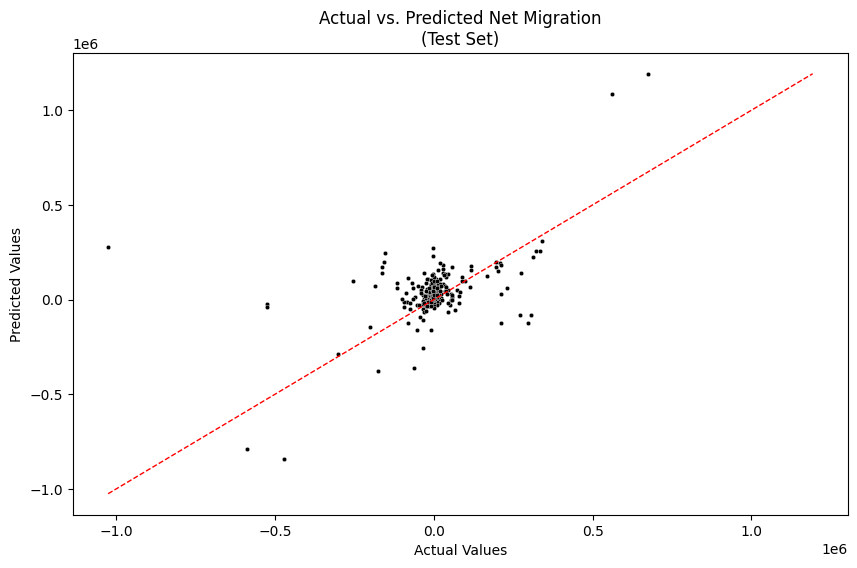

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, color="black", s=10)
# Main diagonal:
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration\n(Test Set)')
plt.show()

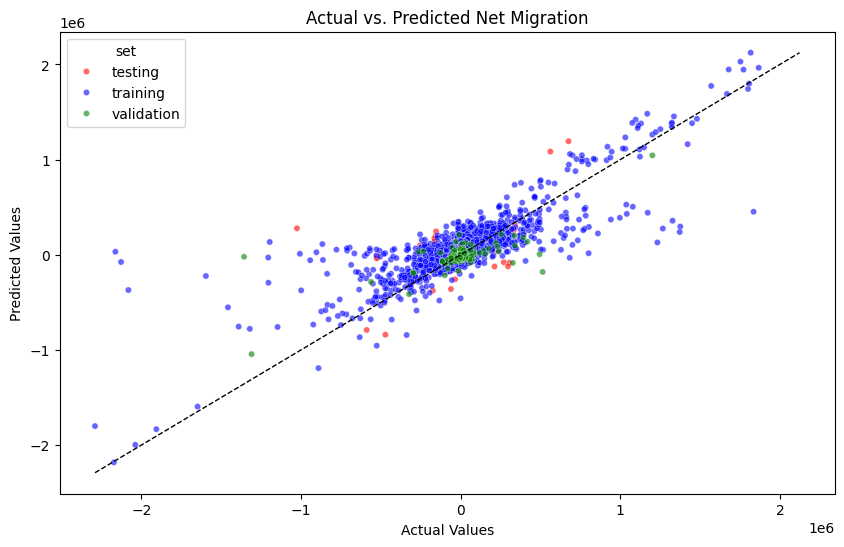

In [22]:
train_pred, train_act = collect_predictions(model, train_loader)
val_pred, val_act = collect_predictions(model, val_loader)

train_pred, train_act = rescale(train_pred, omin, omax), rescale(train_act, omin, omax)
val_pred, val_act = rescale(val_pred, omin, omax), rescale(val_act, omin, omax)

all_predictions = pd.concat([
    pd.DataFrame({"predicted": train_pred, "actual": train_act, "set": "training"}),
    pd.DataFrame({"predicted": val_pred, "actual": val_act, "set": "validation"}),
    pd.DataFrame({"predicted": predictions, "actual": actuals, "set": "testing"})
])

all_predictions['set'] = pd.Categorical(all_predictions['set'], categories=['testing', 'training', 'validation'])
all_predictions = all_predictions.sort_values('set').reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=all_predictions, 
    x="actual",
    y="predicted",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.6
)
# Main diagonal:
min_val = min(min(all_predictions["actual"]), min(all_predictions["predicted"]))
max_val = max(max(all_predictions["actual"]), max(all_predictions["predicted"]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration')
plt.show()

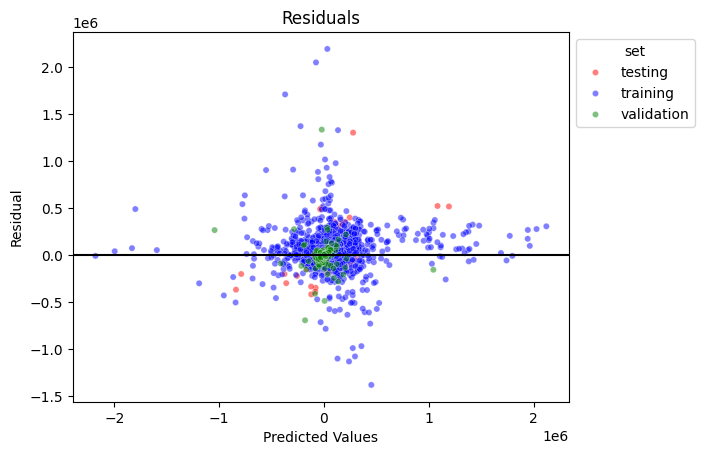

In [23]:
all_predictions["error"] = all_predictions["predicted"] - all_predictions["actual"]
ax = sns.scatterplot(
    data=all_predictions,
    x="predicted",
    y="error",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals')
plt.show()